In [33]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [214]:
DIM = 2
NUM = 100
# 2-D mean of ones
M1 = np.ones((DIM,))
M3 = 3*np.ones((DIM,))
M2 = 2 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(0.2 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(0.15 * np.ones((DIM,)))
C3 = np.diag(0.15*np.ones((DIM,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

NUM = 50
if __name__ == '__main__':
    # generate 50 points from gaussian 1
    x1 = generate_gaussian(M1, C1, NUM)
    x2 = generate_gaussian(M2, C2, NUM)
    x3 = generate_gaussian(M3, C3, NUM)
    # join
    x = np.concatenate((x1, x2, x3), axis = 0)
    # write
    #with open('gaussiandata.pickle', 'wb') as f:
    #    pickle.dump((x, y), f)

In [215]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

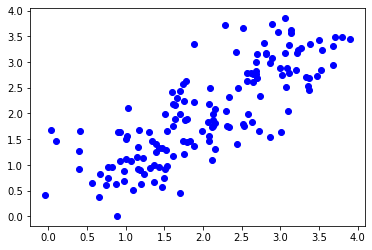

In [216]:
plt.plot(x[:,0],x[:,1],'bo')
plt.show()

In [217]:
def euclidean_distance(x1,x2):
    return np.sqrt(np.sum(np.square(x1-x2)))
    
def kernel_value(dist,bw):
    val = np.exp(-0.5*np.square(float(dist/bw)))
    val = val/(bw*np.sqrt(2*np.pi))
    return val

def neighbours(X,xi,dist = 5):
    valid_pts = []
    for x in X:
        dist_x2xi = distance(x,xi)
        if dist_x2xi < dist:
            valid_pts.append(x)
    return valid_pts

In [286]:
x_copy = np.copy(x)

past_x = []
n_iter = 10

boundary_dist = 1.25*(C1[0][0]+C2[0][0]+C3[0][0])
bandwidth = float(1)/(2*(C1[0][0]+C2[0][0]+C3[0][0]))
for it in range(n_iter):
    for i,xs in enumerate(x_copy):
        neighbours_xs = neighbours(x_copy,xs,boundary_dist)
        #for neighbour in neighbours_xs:
        weight = np.array([kernel_value(euclidean_distance(neighbour,xs),bandwidth) for neighbour in neighbours_xs]).reshape([-1,1]) 
        num = np.sum(np.multiply(weight,neighbours_xs),axis=0)
        den = np.sum(weight)
        x_copy[i] = num/den
    past_x.append(np.copy(x_copy))

In [287]:
final_pts = past_x[-1]
pivot = final_pts[0]
#clusters = {1:[x[0]]}
modes = {1:pivot}
n = 150
included = False
y = np.zeros((n,1))
for i in range(n):
    included = False
    #print(i,final_pts[i],end=" ")
    for (mk,mv) in modes.items():
        #print(mk,mv)
        if euclidean_distance(final_pts[i],mv)<0.1:
            y[i] = mk
            included = True
            break
    #print(included)
    if not included:
        #print('new mode found')
        modes[len(modes.keys())+1] = final_pts[i]
        y[i] = len(modes.keys())+1
        #print(modes)
        #clusters[len(modes.keys())] = x[i]

In [288]:
modes

{1: array([1.24497847, 1.08251483]),
 2: array([1.98271947, 1.84514785]),
 3: array([0.53072836, 1.55553176]),
 4: array([-0.03923024,  0.42096651]),
 5: array([2.68318568, 2.01187407]),
 6: array([3.04033136, 3.03374216]),
 7: array([2.26119419, 3.56482875])}

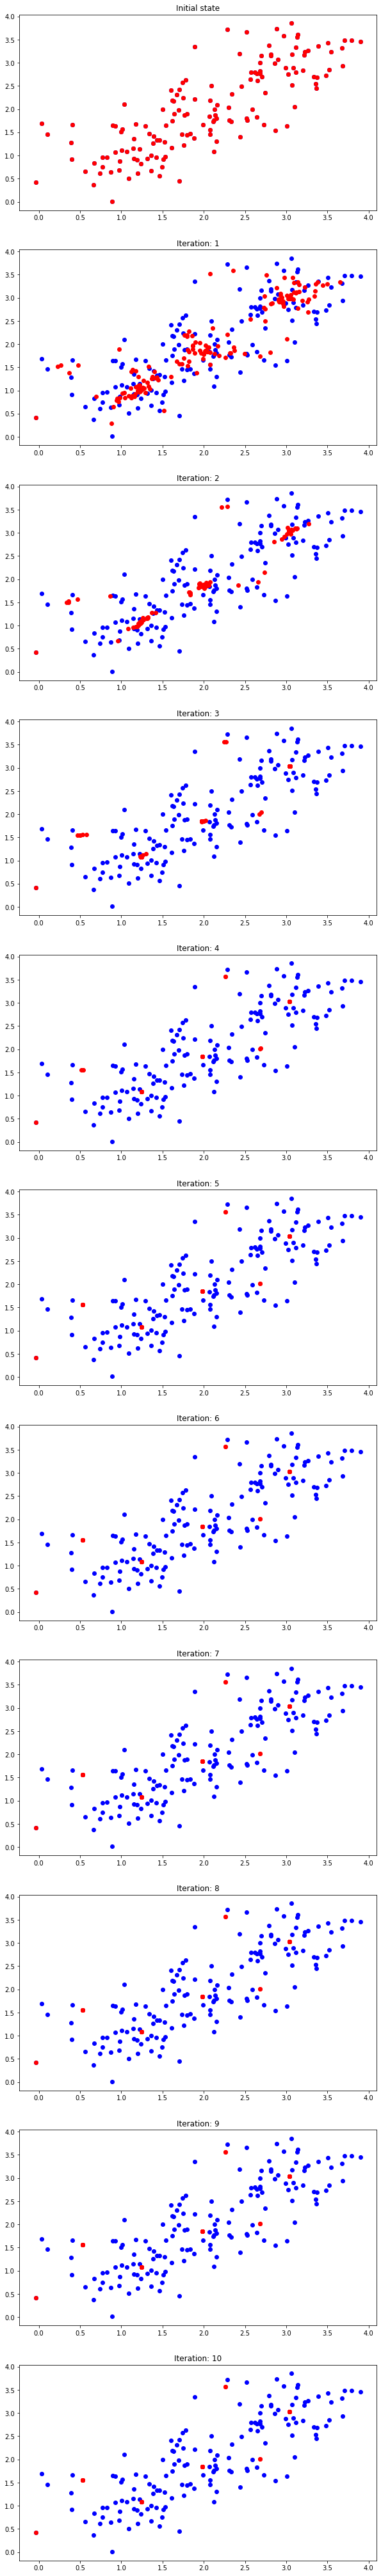

In [289]:
figure = plt.figure(1)
figure.set_size_inches((10, 80))
plt.subplot(n_iter + 2, 1, 1)
plt.title('Initial state')
plt.plot(x[:,0], x[:,1], 'bo')
plt.plot(x[:,0], x[:,1], 'ro')

for i in range(n_iter):
    figure_index = i + 2
    plt.subplot(n_iter + 2, 1, figure_index)
    plt.title('Iteration: %d' % (figure_index - 1))
    plt.plot(x[:,0], x[:,1], 'bo')
    plt.plot(past_x[i][:,0], past_x[i][:,1], 'ro')

In [290]:
COLORS = ['b','g','m','y','r','c','k','w','black','black']

In [291]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

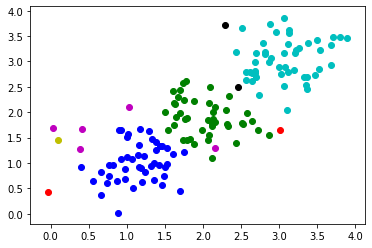

In [292]:
plot_data_with_labels(x,y.astype('int').reshape([-1]))

### sklearn Comparison

In [293]:
from sklearn import cluster

cls = cluster.MeanShift()
clusters = cls.fit(x)

In [294]:
cluster.estimate_bandwidth(x)

0.9348187303640647

In [295]:
y_sk = clusters.labels_

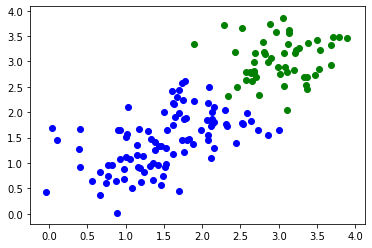

In [296]:
plot_data_with_labels(x,y_sk)

#### Actual number of clusters = 3
#### sklearn output contains 2 clusters
#### My output contains 3 large clusters